In [13]:
import os
print("Current directory:", os.getcwd())
print("Git branch:", os.popen('git branch --show-current').read().strip())

Current directory: /home/ileniag/buzi_ml4cad_noncvd
Git branch: noncvd-7y-alive


In [14]:
# This notebook is used to
# 1. Refine the classifiers to mitigate data imbalance
# 2. Create ensemble classifier
# 3. Perform feature ablation

import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : False,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 300,
})

# suppress sklearn deprecated warnings
import warnings
def warn(*args, **kwargs): pass
warnings.warn = warn

### Read Data

In [ ]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 18
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = mean_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/{n_features}features/{key if extra_path else '' }"
print(path_models)
print(path)

models/27features/
data/27features/


In [16]:
# Read data
df_train = pd.read_csv(f"{path}train.csv", index_col=0)
df_valid = pd.read_csv(f"{path}valid.csv", index_col=0)
df_test = pd.read_csv(f"{path}test.csv", index_col=0)

train, valid, test = df_train.to_numpy(), df_valid.to_numpy(), df_test.to_numpy()
X_train, y_train = train[:, :-1], train[:, -1]
X_valid, y_valid = valid[:, :-1], valid[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
feat_names = list(df_train.columns)

from collections import Counter
print(Counter(y_train))
print(Counter(y_valid))
print(Counter(y_test))

# All the numerical features that can be standarditazed
from utils import get_preprocess_std_num
preprocess_std = get_preprocess_std_num(feat_names)
preprocess_std_all = StandardScaler()

# Preprocessed ready-to-use train and valid set
process_tmp = preprocess_std.fit(X_train)
X_train_std = process_tmp.transform(X_train)
X_valid_std = process_tmp.transform(X_valid)

Counter({np.float64(1.0): 3705, np.float64(0.0): 505})
Counter({np.float64(1.0): 1235, np.float64(0.0): 169})
Counter({np.float64(1.0): 1235, np.float64(0.0): 169})


In [17]:
from ensemble import build_ensemble_path, evaluate_ensemble, predict_ensemble
from joblib import load
from sklearn.calibration import CalibratedClassifierCV
# Run file 3.2 to find the best ensemble if this list is empty
# Top model: 27 parameters, ensemble with not calibrated models -> knn, rf
top_model = ["knn","rf", "gb"]
ensemble = build_ensemble_path(top_model, path_models)
ensemble_calibrated = []
for name,model in ensemble:
    print(f"Calibrating: {name}")
    # TOP ENSEMBLE DOESN'T USE CALIBRATED MODELS
    #calibrated_clf = CalibratedClassifierCV(model, cv=5)
    #calibrated_clf.fit(X_train, y_train)
    ensemble_calibrated.append((name,model))
names = list(map(lambda x: x[0], ensemble_calibrated))
ensemble = list(map(lambda x: x[1], ensemble_calibrated))
evaluate_ensemble(ensemble, X_valid, y_valid)
(_auroc, _f1_score, _brier) = evaluate_ensemble(ensemble, X_test, y_test)
print (f"Result on TEST SET: {_auroc} | {_f1_score} | {_brier}")

Calibrating: knn
Calibrating: rf
Calibrating: gb
              precision    recall  f1-score   support

         0.0      0.476     0.237     0.316       169
         1.0      0.902     0.964     0.932      1235

    accuracy                          0.877      1404
   macro avg      0.689     0.601     0.624      1404
weighted avg      0.851     0.877     0.858      1404

auroc 0.806
brier 0.092
[[  40  129]
 [  44 1191]]
              precision    recall  f1-score   support

         0.0      0.587     0.260     0.361       169
         1.0      0.906     0.975     0.939      1235

    accuracy                          0.889      1404
   macro avg      0.746     0.618     0.650      1404
weighted avg      0.868     0.889     0.870      1404

auroc 0.809
brier 0.088
[[  44  125]
 [  31 1204]]
Result on TEST SET: 0.8088110581414847 | 0.6499066520037851 | 0.08844500140820866


In [18]:
##### from sklearn.calibration import calibration_curve
train_prob, train_pred = predict_ensemble(ensemble, X_train, y_train)
valid_prob, valid_pred = predict_ensemble(ensemble, X_valid, y_valid)
test_prob, test_pred = predict_ensemble(ensemble, X_test, y_test)
print(sum(y_train == train_pred) / len(df_train))
print(sum(y_valid == valid_pred) / len(df_valid))
print(sum(y_test == test_pred) / len(df_test))

df_train["ModelOutput"] = train_prob[:, 1]
df_valid["ModelOutput"] = valid_prob[:, 1]
df_test["ModelOutput"] = test_prob[:, 1]
extra_test_output = df_test[['ModelOutput']]
"""true_pos, pred_pos = calibration_curve(y_test, test_prob[:, 1], n_bins=10)
plt.plot(pred_pos,
         true_pos, 
         marker='o', 
         linewidth=1, 
         label='Ensemble')
plt.plot([0, 1], 
         [0, 1], 
         linestyle='--', 
         label='Perfectly Calibrated')

# plt.title('Probability Calibration Curve')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.legend(loc='best')"""
extra_test_output.to_csv(f"{path}extra_test_output.csv")
plt.savefig(f"{path_images}calibration1.png")

0.9498812351543943
0.8767806267806267
0.8888888888888888


<Figure size 2400x1500 with 0 Axes>

In [19]:
df_cvd = pd.read_csv("./data/raw/data_cvd.csv", index_col=0, decimal='.')
df_cvd["Follow Up Data"] = pd.to_datetime(df_cvd["Follow Up Data"])
df_cvd["Data prelievo"] = pd.to_datetime(df_cvd["Data prelievo"])
df_cvd["Elapsed"] = (df_cvd["Follow Up Data"] - df_cvd["Data prelievo"]).map(lambda x: x.days // 365)
df_plot = df_test.join(df_cvd["Elapsed"])

assert len(df_plot) == len(df_test)

[0. 0. 0. ... 0. 0. 0.]


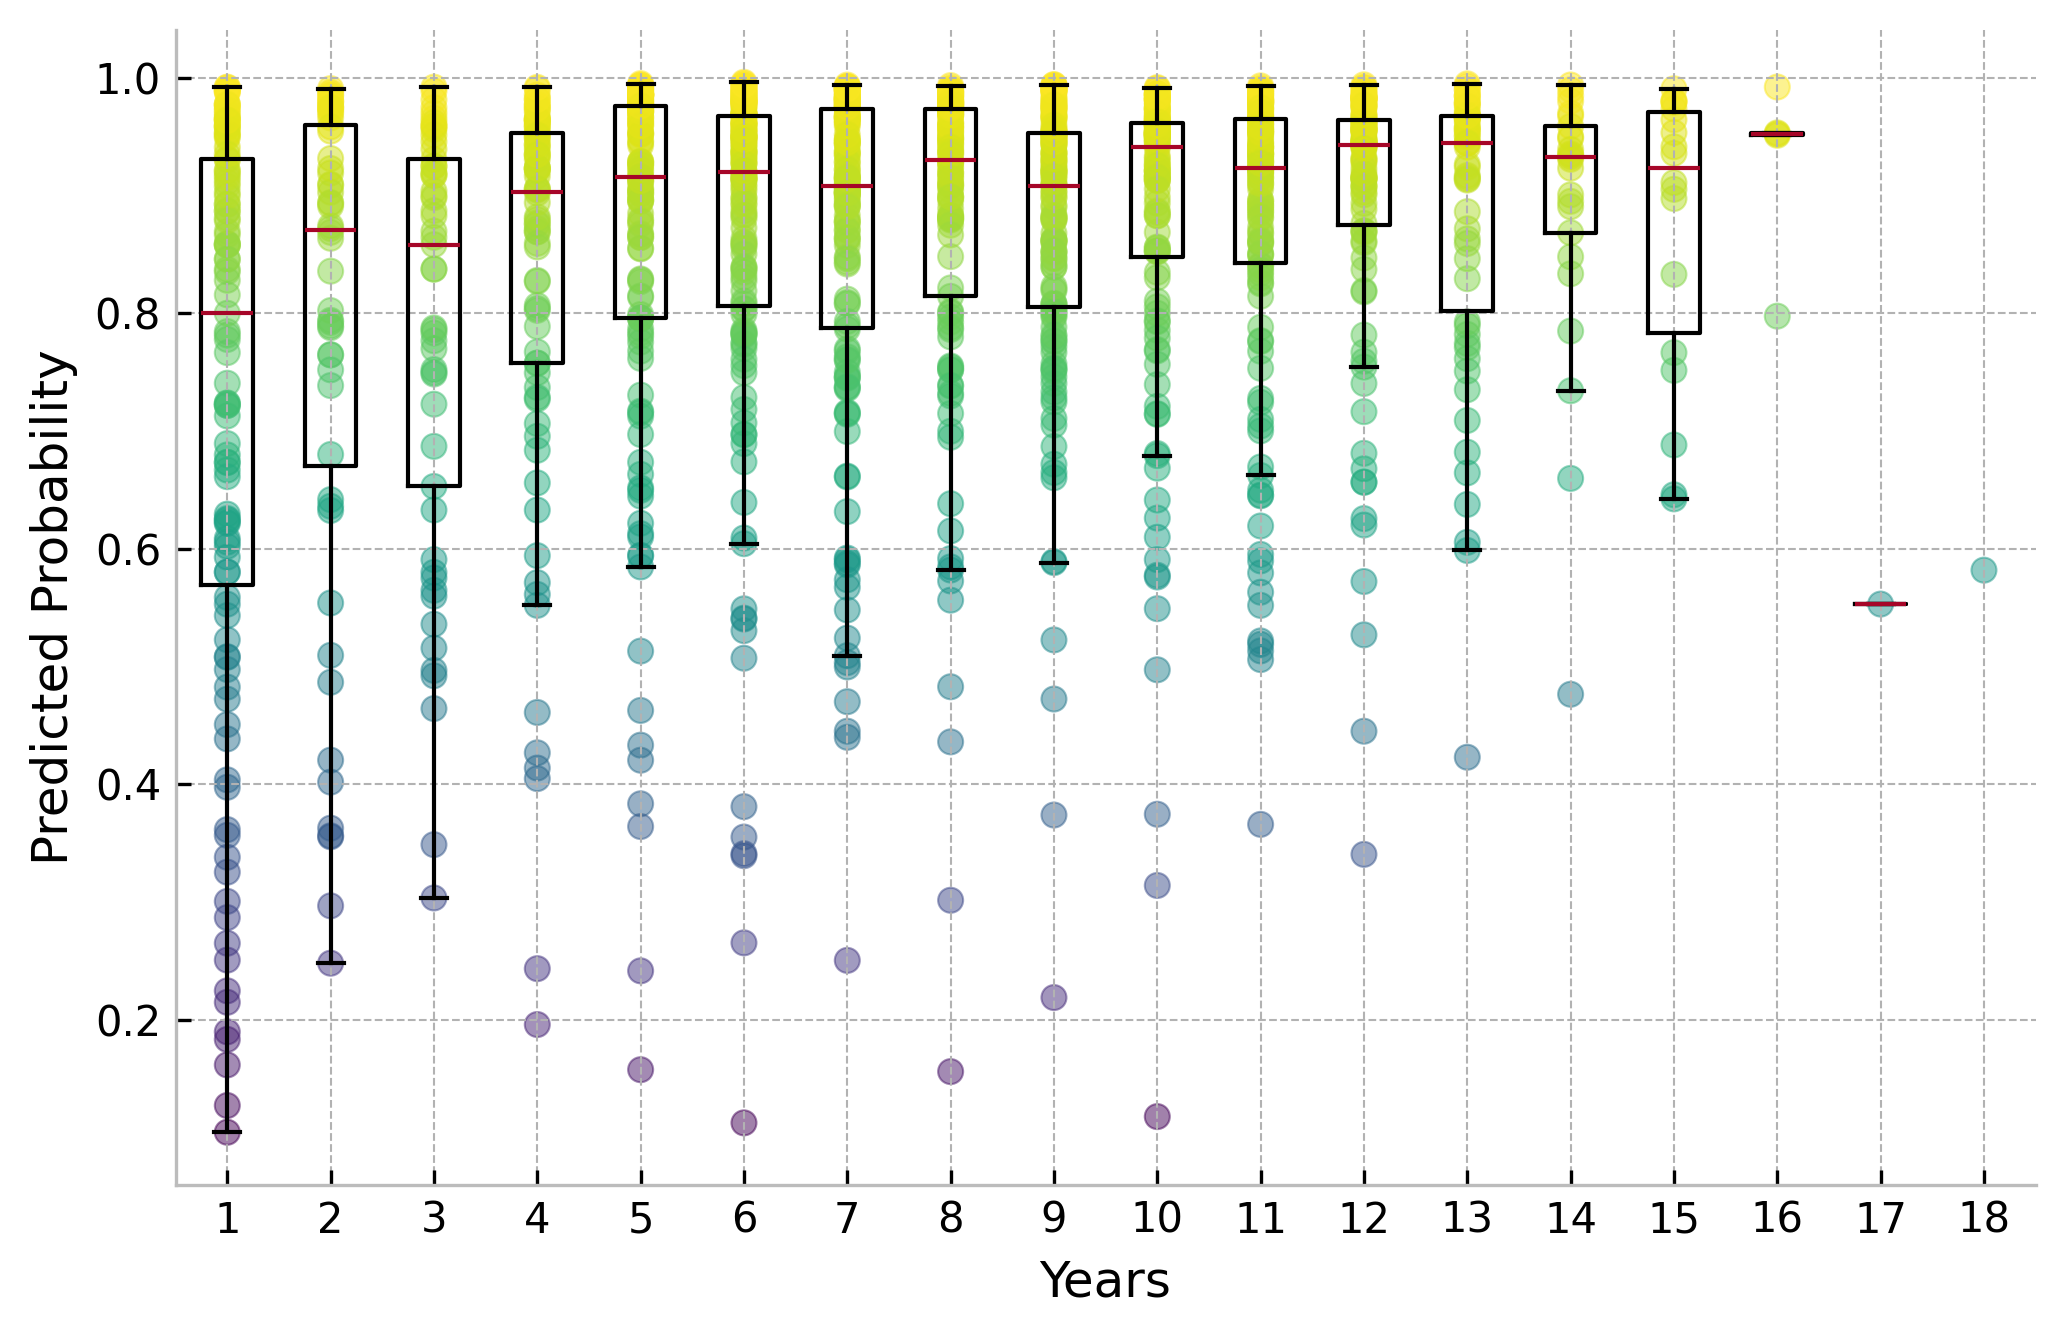

In [20]:
plt.figure(rasterized=True)
# group by years and take only the values
boxes = list(map(lambda x: list(x[1].values), list(df_plot.groupby("Elapsed")["ModelOutput"])))
boxes = boxes[:-1] + [[]]
plt.boxplot(boxes, showfliers=False)

n = 0.
noise = (np.random.rand(len(df_plot)) * n) - (n / 2)
print(noise)
#noise = 0
plt.scatter(df_plot["Elapsed"]+1+noise, df_plot["ModelOutput"], c=df_plot["ModelOutput"], alpha=0.5)

plt.xlabel("Years")
plt.ylabel("Predicted Probability")
# plt.xticks(range(18), [f"n={len(box)}" for box in boxes])
plt.savefig(f"{path_images}calibration.png")
#from PIL import Image
#png2 = Image.open("figures/calibration.png")
#png2.save("figures/calibration.tiff")

### Feature Ablation

In [21]:
from sklearn.inspection import permutation_importance
from utils import safe_feature_index

def get_univariate_ablation_results(X, y):
    """For each feature we set it to its mean value and save the resulting metrics"""

    features = list(df_valid.columns)
    del features[-2:]
    auroc, f1_macro = [], []
    for feature in range(len(features)):
        X_copy = X.copy()
        X_copy[:, feature] = X_copy[:, feature].mean()
        # Predict the ensemble with the values replaced with the mean
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)
        auroc.append((features[feature], round(roc_auc_score(y, y_proba[:, 1]), 3)))
        f1_macro.append((features[feature], round(f1_score(y, y_pred, average="macro"), 3)))
    
    return auroc, f1_macro


def get_multivariate_ablation_results(feat_clusters, X, y):
    """For each cluster of features, we set each feature of a group to its mean and save the resulting metrics"""

    auroc, f1_macro = [], []
    for feat_cluster in feat_clusters:
        # Create a copy of the dataset
        X_copy = X.copy()
        result = []
        for cluster in feat_cluster:
            # index = feat_names.index(cluster)
            index = safe_feature_index(cluster, feat_names)
            result.append(index)
            X_copy[:, index] = X_copy[:, index].mean()

        # Predict
        y_proba, y_pred = predict_ensemble(ensemble, X_copy, y)
        auroc.append(round(roc_auc_score(y, y_proba[:, 1]), 3))
        f1_macro.append(round(f1_score(y, y_pred, average="macro"), 3))
    
    return auroc, f1_macro

In [22]:
# Univariate ablation
auroc, f1_macro = get_univariate_ablation_results(X_test, y_test)
ensemble_f1_score = round(f1_score(y_test, test_pred, average="macro"), 3)
p = pd.DataFrame({
    "auroc": [x[1] for x in auroc], 
    "f1_macro": [x[1] for x in f1_macro],
    "importance" : [ ensemble_f1_score / x[1] for x in f1_macro],
    }, index=feat_names[:-1]).sort_values("importance",ascending = False)
p.to_csv(f"{path_images}extra_ablation_uni_test.csv", float_format = '%.5f')

In [23]:
# Multivariate hierarchical ablation
ensemble_f1_score = round(f1_score(y_test, test_pred, average="macro"), 3)
with open(f"{path_images}feat_cluster_hier.df", "rb") as f:
    df_clusters = pickle.load(f)
print(df_clusters)
auroc, f1_macro = get_multivariate_ablation_results(df_clusters, X_test, y_test)
p = pd.DataFrame({"cluster": df_clusters, "auroc": auroc, "f1_macro": f1_macro, "importance" : [ ensemble_f1_score / x for x in f1_macro] })
p.to_csv(f"{path_images}multivariate_ablation_hier_nomeds.csv", float_format = '%.5f')

0                                [fT4, Ipertiroidismo]
1                             [fT3, Euthyroid, Low T3]
2    [TSH, Subclinical primary hypothyroidism (SCH)...
3                                      [Ipotiroidismo]
4                             [Diabetes, Hypertension]
5    [Previous CABG, PCI, Previous MI, Post IDC, LVEF]
6                                      [Gender, Smoke]
7    [Angina, Angiography, Vessels, Documented rest...
8                           [Age, Atrial Fibrillation]
9                                           [Acute MI]
Name: Feature, dtype: object


In [24]:
from auto_export_notebook import export_current_notebook


html_path = export_current_notebook(
    globals(),
    wait_for_disk_save=True,   # wait for Auto Save
    wait_timeout_sec=8.0
)
print("Exported to:", html_path)

<IPython.core.display.Javascript object>

Exported to: /home/ileniag/buzi_ml4cad_noncvd/exported_notebooks/3_ensemble_ablations_27features_20251001_153653.html
